# ベイジアンネットワーク

ベイジアンネットワーク（Bayesian network, Bayesnet）は複数の確率変数の間の依存関係をDAGで表現するモデル

## 分析の流れ

### 確率変数間の関係性の表現

確率変数間の関係を確率の積で表す。例えば$X \to Y$という依存関係（因果関係）は

$$
P(X, Y) = P(Y|X) P(X)
$$

と分解されると考える。$P(Y|X)$は$X$の値によって決まるので、$X$の値に応じて$Y$が決まるという依存関係を表す。

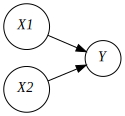

In [1]:
import graphviz
graphviz.Source("""
digraph g {
    graph [rankdir = LR];
    node[shape = circle];
        X1 [label=<<I>X1</I>>]
        X2 [label=<<I>X2</I>>]
        Y [label=<<I>Y</I>>]
    edge [];
        {X1, X2} -> Y
}
""")

上の図の場合、

$$
P(Y, X_1, X_2)
= P(Y | X_1, X_2) P(X_1) P(X_2)
$$

となる


この条件付き確率を確率変数間の関係性として扱い、 **条件付き確率表** （Conditional Probabilities Tables: **CPT**）を使って表現する。

（ CPD (Conditional Probability Distribution) という呼び方もある様子？）

CPTは単に確率変数の値と確率の表である。例えば以下のようになる

In [2]:
import numpy as np
import pandas as pd

cpt_x1 = pd.DataFrame([
    {"x1": 0, "P(x1)": 0.6},
    {"x1": 1, "P(x1)": 0.4},
])
cpt_x1

,x1,P(x1)
0,0,0.6
1,1,0.4


In [3]:
import numpy as np
import pandas as pd

cpt_x2 = pd.DataFrame([
    {"x2": 0, "P(x2)": 0.4},
    {"x2": 1, "P(x2)": 0.6},
])
cpt_x2

,x2,P(x2)
0,0,0.4
1,1,0.6


In [4]:
import numpy as np
import pandas as pd

cpt_y = pd.DataFrame([
    {"x1": 0, "x2": 0, "y": 0, "P(y=0|x1,x2)": 0.2},
    {"x1": 0, "x2": 1, "y": 0, "P(y=0|x1,x2)": 0.3},
    {"x1": 1, "x2": 0, "y": 0, "P(y=0|x1,x2)": 0.4},
    {"x1": 1, "x2": 1, "y": 0, "P(y=0|x1,x2)": 0.1},
])
del cpt_y["y"]
cpt_y["P(y=1|x1,x2)"] = 1 - cpt_y["P(y=0|x1,x2)"]
cpt_y

,x1,x2,"P(y=0|x1,x2)","P(y=1|x1,x2)"
0,0,0,0.2,0.8
1,0,1,0.3,0.7
2,1,0,0.4,0.6
3,1,1,0.1,0.9


### パラメータの推定

最尤推定でCPTの各セルにいれるべき確率（これをパラメータ$\theta$と表すことにする）を推定する。

確率変数のインデックスを$i$、確率変数の値を$j$、条件付き確率については条件を$k$とすると、推定したいパラメータは$\theta_{i,j,k}$となる

例えば$P(x=1)$は$x=1$を満たすサンプル数$N_{1}$と全体のサンプル数の比率

$$
P(x=1) = \frac{N_{1}}{N}
$$

で求められるように、

同様に、条件$i,j,k$を満たすサンプル数を$N_{i,j,k}$と書くことにすると

$$
\theta_{i,j,k} = \frac{N_{i,j,k}}{N}
$$

となる

### モデルの評価

データに対するネットワークの当てはまりの良さの指標にはAICやBICなどが使われる

BICは

$$
BIC = -2l(\theta|X) + k(\log N)
$$

$X$はデータ、$k$はモデルのパラメータ数、$N$はサンプルサイズ、$l(\theta|X)$はモデルの対数尤度



## 分析例（スクラッチ）

### データの用意

まずデータを生成する。上記のCPTを真の値として、そこから疑似乱数でデータを生成する。

In [5]:
import numpy as np

n = 100
np.random.seed(0)

x1 = np.random.binomial(n=1, p=cpt_x1.query("x1 == 1")["P(x1)"].iloc[0], size=n)
x2 = np.random.binomial(n=1, p=cpt_x2.query("x2 == 1")["P(x2)"].iloc[0], size=n)
df = pd.DataFrame({"x1": x1, "x2": x2})

# yを生成
for x1 in [0, 1]:
    for x2 in [0, 1]:
        q = f"x1 == {x1} & x2 == {x2}"
        values = np.random.binomial(
            n=1,
            p = cpt_y.query(q)["P(y=1|x1,x2)"].iloc[0],
            size = df.query(q).shape[0],
        )
        df.loc[df.query(q).index, "y"] = values
df = df.astype({"y": "int"})

df.tail(3)

,x1,x2,y
97,0,1,1
98,1,1,0
99,0,1,1


### パラメータの推定

パラメータは$\theta_{i,j,k}$を求めていく

$$
\theta_{i,j,k} = \frac{N_{i,j,k}}{N}
$$

確率変数のインデックスを$i$、確率変数の値を$j$、条件付き確率の条件が$k$である。

$P(x_1=0)$については、条件付き確率ではないので$k=[]$と表すことにすると$\theta_{1, 0, []}$となる


In [6]:
J = [0, 1]

In [7]:
# θ_{1,j,[]}
theta_x1 = []
# サンプル数 N_ijkも保存する
n_x1 = []

for j in J:
    n_ij = df.query(f"x1 == {j}").shape[0]
    theta_x1.append(n_ij / n)
    n_x1.append(n_ij)

theta_x1

[0.62, 0.38]

In [8]:
# θ_{2,j,[]}
theta_x2 = []
# サンプル数 N_ijkも保存する
n_x2 = []

for j in J:
    n_ij = df.query(f"x2 == {j}").shape[0]
    theta_x2.append(n_ij / n)
    n_x2.append(n_ij)

theta_x2

[0.44, 0.56]

In [9]:
# 条件をリストアップ
k_values = []
for x1 in [0, 1]:
    for x2 in [0, 1]:
        k_values.append((x1, x2))
k_values

[(0, 0), (0, 1), (1, 0), (1, 1)]

In [10]:
# θ_{3,j,[]}
theta_y = np.zeros(shape=(2, 4))  # j * k
n_y = np.zeros(shape=(2, 4))  # j * k
for k, (x1, x2) in enumerate(k_values):
    q = f"x1 == {x1} & x2 == {x2}"
    for j in J:
        n_ijk = df.query(q).query(f"y == {j}").shape[0]
        theta_y[j, k] = n_ijk / n
        n_y[j, k] = n_ijk
theta_y

array([[0.06, 0.08, 0.08, 0.03],
       [0.23, 0.25, 0.07, 0.2 ]])

### モデルの評価

モデルの対数尤度$l(\theta|X)$に比例する値を計算する

$$
l\left(\theta \mid \boldsymbol{X}\right) \propto \sum_i \sum_j \sum_k\left(N_{i j k}\right) \log \hat{\theta}_{i, j, k}
$$

In [11]:
thetas = [theta_x1, theta_x2, theta_y]
nums = [n_x1, n_x2, n_y]

In [12]:
log_likelihood = 0
for i in range(len(thetas)):
    for j in [0, 1]:
        if i == 2:
            for k in range(len(k_values)):
                log_likelihood += nums[i][j][k] * np.log(thetas[i][j][k])
        else:
            log_likelihood += nums[i][j] * np.log(thetas[i][j])
log_likelihood

-322.07467382966473


$$
BIC = -2l(\theta|X) + k(\log N)
$$

$X$はデータ、$k$はモデルのパラメータ数、$N$はサンプルサイズ、$l(\theta|X)$はモデルの対数尤度



In [13]:
# 『Pythonによる因果分析』で見てもkの値がよくわからなかった
k = len(thetas) * len(J)
bic = -2 * log_likelihood + k * np.log(n)
bic

671.780368775258

## pympyパッケージによる推定

[Bayesian Network — pgmpy 0.1.23 documentation](https://pgmpy.org/models/bayesiannetwork.html)

In [16]:
from pgmpy.models import DiscreteBayesianNetwork 

DAG = [('x1', 'y'), ('x2', 'y')] # x1 -> y, x2 -> y
model = DiscreteBayesianNetwork (DAG)

model.fit(df)
model.get_cpds()

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'x1': 'N', 'x2': 'N', 'y': 'N'}


[<TabularCPD representing P(x1:2) at 0x73297ce6ac80>,
 <TabularCPD representing P(y:2 | x1:2, x2:2) at 0x73297ce6ada0>,
 <TabularCPD representing P(x2:2) at 0x73297ce69c60>]

In [17]:
# 推定されたCPT
print(model.get_cpds()[0])

+-------+------+
| x1(0) | 0.62 |
+-------+------+
| x1(1) | 0.38 |
+-------+------+


## 参考文献

- 『Pythonによる因果分析』
- [本村陽一. (2000). ベイジアンネットワーク. 電子情報通信学会誌, 83(8), 645-646.](https://staff.aist.go.jp/y.motomura/paper/nc02.pdf)
- [グラフィカルモデルの基礎〜ベイジアンネットワークについて〜 - YouTube](https://www.youtube.com/watch?v=qBhpk-o_X7s&ab_channel=AyakaSakata_Lectures)
- [【因果を利用した分析】ベイジアンネットワークで見る変数の因果関係【いろんな分析 vol. 5 】 #060 #VRアカデミア - YouTube](https://www.youtube.com/watch?v=knCbMFQJXxY&ab_channel=AIciaSolidProject)